In [1]:
from autotsc import utils
import os
from aeon.datasets.tsc_datasets import univariate
import random
from itertools import product
from tqdm import tqdm
import polars as pl
import numpy as np
from datetime import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from aeon.classification.convolution_based import RocketClassifier
import matplotlib.pyplot as plt

In [2]:
write_dir = "experiments/automl_val_vs_test_correlation"
os.makedirs(write_dir, exist_ok=True)

datasets = list(univariate)#[:15]
random.shuffle(datasets)
model_types = ['ridge', 'randomforest']#, 'hgb', 'lda']

n_jobs = -1
n_runs = 5

In [3]:
def get_model(model_name):
    from sklearn.linear_model import RidgeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import HistGradientBoostingClassifier
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

    if model_name == 'ridge':
        alphas=np.logspace(-3, 3, 10)
        alpha = np.random.choice(alphas)
        model = RidgeClassifier(alpha=alpha)
        return RocketClassifier(estimator=model, n_jobs=-1)
    elif model_name == 'randomforest':
        ccp_alphas = [0.0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]
        ccp_alpha = np.random.choice(ccp_alphas)
        model = RandomForestClassifier(n_jobs=n_jobs, ccp_alpha=ccp_alpha)
        return RocketClassifier(estimator=model, n_jobs=-1)
    elif model_name == 'hgb':
        max_leaf_nodes_values = [4, 8, 15, 31, 47, 63, 95, 127, 191, 255]
        max_leaf_nodes = np.random.choice(max_leaf_nodes_values)
        model = HistGradientBoostingClassifier(max_leaf_nodes=max_leaf_nodes)
        return RocketClassifier(estimator=model, n_jobs=-1)
    elif model_name == 'lda':
        model = LinearDiscriminantAnalysis()
        return RocketClassifier(estimator=model, n_jobs=-1)
    else:
        raise ValueError(f"Unknown model name: {model_name}")

In [4]:
all_combinations = list(product(datasets, range(n_runs), model_types))

last_dataset = None
X_train, y_train, X_test, y_test = None, None, None, None

for ds, run, model_name in tqdm(all_combinations, desc="Processing"):
    try: 
        model = get_model(model_name)
        stats = {
            "dataset": ds,
            "run": run,
            "model": model_name,
        }

        hash_val = pl.DataFrame([stats]).hash_rows(
            seed=42, seed_1=1, seed_2=2, seed_3=3
        ).item()
        file = f"{write_dir}/{hash_val}.parquet"

        if os.path.exists(file):
            print(f'Skipping {stats}')
            continue
        else:
            print(f'Processing {stats}')

        if ds != last_dataset:
            X_train, y_train, X_test, y_test = utils.load_dataset(ds)
            last_dataset = ds


        X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

        model.fit(X_train_, y_train_)
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        y_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_pred)

        stats["test_accuracy"] = test_accuracy
        stats["val_accuracy"] = val_accuracy

        df_stat = pl.DataFrame([stats])
        df_stat.write_parquet(file)

    except Exception as e:
        print(f"Error processing {ds}, run {run}, model {model_name}: {e}")
        continue

Processing:   6%|▌         | 75/1280 [00:00<00:01, 725.77it/s]

Skipping {'dataset': 'AllGestureWiimoteY', 'run': 0, 'model': 'ridge'}
Skipping {'dataset': 'AllGestureWiimoteY', 'run': 0, 'model': 'randomforest'}
Skipping {'dataset': 'AllGestureWiimoteY', 'run': 1, 'model': 'ridge'}
Skipping {'dataset': 'AllGestureWiimoteY', 'run': 1, 'model': 'randomforest'}
Skipping {'dataset': 'AllGestureWiimoteY', 'run': 2, 'model': 'ridge'}
Skipping {'dataset': 'AllGestureWiimoteY', 'run': 2, 'model': 'randomforest'}
Skipping {'dataset': 'AllGestureWiimoteY', 'run': 3, 'model': 'ridge'}
Skipping {'dataset': 'AllGestureWiimoteY', 'run': 3, 'model': 'randomforest'}
Skipping {'dataset': 'AllGestureWiimoteY', 'run': 4, 'model': 'ridge'}
Skipping {'dataset': 'AllGestureWiimoteY', 'run': 4, 'model': 'randomforest'}
Skipping {'dataset': 'ToeSegmentation1', 'run': 0, 'model': 'ridge'}
Skipping {'dataset': 'ToeSegmentation1', 'run': 0, 'model': 'randomforest'}
Skipping {'dataset': 'ToeSegmentation1', 'run': 1, 'model': 'ridge'}
Skipping {'dataset': 'ToeSegmentation1', 

Processing:  16%|█▋        | 210/1280 [00:00<00:02, 504.70it/s]

Skipping {'dataset': 'PigAirwayPressure', 'run': 1, 'model': 'ridge'}
Skipping {'dataset': 'PigAirwayPressure', 'run': 1, 'model': 'randomforest'}
Skipping {'dataset': 'PigAirwayPressure', 'run': 2, 'model': 'ridge'}
Skipping {'dataset': 'PigAirwayPressure', 'run': 2, 'model': 'randomforest'}
Skipping {'dataset': 'PigAirwayPressure', 'run': 3, 'model': 'ridge'}
Skipping {'dataset': 'PigAirwayPressure', 'run': 3, 'model': 'randomforest'}
Skipping {'dataset': 'PigAirwayPressure', 'run': 4, 'model': 'ridge'}
Skipping {'dataset': 'PigAirwayPressure', 'run': 4, 'model': 'randomforest'}
Skipping {'dataset': 'Haptics', 'run': 0, 'model': 'ridge'}
Skipping {'dataset': 'Haptics', 'run': 0, 'model': 'randomforest'}
Skipping {'dataset': 'Haptics', 'run': 1, 'model': 'ridge'}
Skipping {'dataset': 'Haptics', 'run': 1, 'model': 'randomforest'}
Skipping {'dataset': 'Haptics', 'run': 2, 'model': 'ridge'}
Skipping {'dataset': 'Haptics', 'run': 2, 'model': 'randomforest'}
Skipping {'dataset': 'Haptics',

Processing:  31%|███       | 394/1280 [00:00<00:01, 723.47it/s]

Skipping {'dataset': 'Worms', 'run': 2, 'model': 'randomforest'}
Skipping {'dataset': 'Worms', 'run': 3, 'model': 'ridge'}
Skipping {'dataset': 'Worms', 'run': 3, 'model': 'randomforest'}
Skipping {'dataset': 'Worms', 'run': 4, 'model': 'ridge'}
Skipping {'dataset': 'Worms', 'run': 4, 'model': 'randomforest'}
Skipping {'dataset': 'ProximalPhalanxOutlineAgeGroup', 'run': 0, 'model': 'ridge'}
Skipping {'dataset': 'ProximalPhalanxOutlineAgeGroup', 'run': 0, 'model': 'randomforest'}
Skipping {'dataset': 'ProximalPhalanxOutlineAgeGroup', 'run': 1, 'model': 'ridge'}
Skipping {'dataset': 'ProximalPhalanxOutlineAgeGroup', 'run': 1, 'model': 'randomforest'}
Skipping {'dataset': 'ProximalPhalanxOutlineAgeGroup', 'run': 2, 'model': 'ridge'}
Skipping {'dataset': 'ProximalPhalanxOutlineAgeGroup', 'run': 2, 'model': 'randomforest'}
Skipping {'dataset': 'ProximalPhalanxOutlineAgeGroup', 'run': 3, 'model': 'ridge'}
Skipping {'dataset': 'ProximalPhalanxOutlineAgeGroup', 'run': 3, 'model': 'randomforest

Processing:  49%|████▉     | 633/1280 [00:00<00:00, 1000.91it/s]

Skipping {'dataset': 'Wine', 'run': 0, 'model': 'randomforest'}
Skipping {'dataset': 'Wine', 'run': 1, 'model': 'ridge'}
Skipping {'dataset': 'Wine', 'run': 1, 'model': 'randomforest'}
Skipping {'dataset': 'Wine', 'run': 2, 'model': 'ridge'}
Skipping {'dataset': 'Wine', 'run': 2, 'model': 'randomforest'}
Skipping {'dataset': 'Wine', 'run': 3, 'model': 'ridge'}
Skipping {'dataset': 'Wine', 'run': 3, 'model': 'randomforest'}
Skipping {'dataset': 'Wine', 'run': 4, 'model': 'ridge'}
Skipping {'dataset': 'Wine', 'run': 4, 'model': 'randomforest'}
Skipping {'dataset': 'EOGVerticalSignal', 'run': 0, 'model': 'ridge'}
Skipping {'dataset': 'EOGVerticalSignal', 'run': 0, 'model': 'randomforest'}
Skipping {'dataset': 'EOGVerticalSignal', 'run': 1, 'model': 'ridge'}
Skipping {'dataset': 'EOGVerticalSignal', 'run': 1, 'model': 'randomforest'}
Skipping {'dataset': 'EOGVerticalSignal', 'run': 2, 'model': 'ridge'}
Skipping {'dataset': 'EOGVerticalSignal', 'run': 2, 'model': 'randomforest'}
Skipping {'

Processing:  58%|█████▊    | 737/1280 [00:00<00:00, 898.66it/s] 

Skipping {'dataset': 'ShapeletSim', 'run': 4, 'model': 'randomforest'}
Skipping {'dataset': 'WordSynonyms', 'run': 0, 'model': 'ridge'}
Skipping {'dataset': 'WordSynonyms', 'run': 0, 'model': 'randomforest'}
Skipping {'dataset': 'WordSynonyms', 'run': 1, 'model': 'ridge'}
Skipping {'dataset': 'WordSynonyms', 'run': 1, 'model': 'randomforest'}
Skipping {'dataset': 'WordSynonyms', 'run': 2, 'model': 'ridge'}
Skipping {'dataset': 'WordSynonyms', 'run': 2, 'model': 'randomforest'}
Skipping {'dataset': 'WordSynonyms', 'run': 3, 'model': 'ridge'}
Skipping {'dataset': 'WordSynonyms', 'run': 3, 'model': 'randomforest'}
Skipping {'dataset': 'WordSynonyms', 'run': 4, 'model': 'ridge'}
Skipping {'dataset': 'WordSynonyms', 'run': 4, 'model': 'randomforest'}
Skipping {'dataset': 'UMD', 'run': 0, 'model': 'ridge'}
Skipping {'dataset': 'UMD', 'run': 0, 'model': 'randomforest'}
Skipping {'dataset': 'UMD', 'run': 1, 'model': 'ridge'}
Skipping {'dataset': 'UMD', 'run': 1, 'model': 'randomforest'}
Skippi

Processing:  72%|███████▏  | 922/1280 [00:01<00:00, 844.10it/s]

Skipping {'dataset': 'ElectricDevices', 'run': 4, 'model': 'randomforest'}
Skipping {'dataset': 'FreezerSmallTrain', 'run': 0, 'model': 'ridge'}
Skipping {'dataset': 'FreezerSmallTrain', 'run': 0, 'model': 'randomforest'}
Skipping {'dataset': 'FreezerSmallTrain', 'run': 1, 'model': 'ridge'}
Skipping {'dataset': 'FreezerSmallTrain', 'run': 1, 'model': 'randomforest'}
Skipping {'dataset': 'FreezerSmallTrain', 'run': 2, 'model': 'ridge'}
Skipping {'dataset': 'FreezerSmallTrain', 'run': 2, 'model': 'randomforest'}
Skipping {'dataset': 'FreezerSmallTrain', 'run': 3, 'model': 'ridge'}
Skipping {'dataset': 'FreezerSmallTrain', 'run': 3, 'model': 'randomforest'}
Skipping {'dataset': 'FreezerSmallTrain', 'run': 4, 'model': 'ridge'}
Skipping {'dataset': 'FreezerSmallTrain', 'run': 4, 'model': 'randomforest'}
Skipping {'dataset': 'MixedShapesSmallTrain', 'run': 0, 'model': 'ridge'}
Skipping {'dataset': 'MixedShapesSmallTrain', 'run': 0, 'model': 'randomforest'}
Skipping {'dataset': 'MixedShapesSm

Processing:  88%|████████▊ | 1123/1280 [00:01<00:00, 896.52it/s]

Skipping {'dataset': 'MoteStrain', 'run': 1, 'model': 'ridge'}
Skipping {'dataset': 'MoteStrain', 'run': 1, 'model': 'randomforest'}
Skipping {'dataset': 'MoteStrain', 'run': 2, 'model': 'ridge'}
Skipping {'dataset': 'MoteStrain', 'run': 2, 'model': 'randomforest'}
Skipping {'dataset': 'MoteStrain', 'run': 3, 'model': 'ridge'}
Skipping {'dataset': 'MoteStrain', 'run': 3, 'model': 'randomforest'}
Skipping {'dataset': 'MoteStrain', 'run': 4, 'model': 'ridge'}
Skipping {'dataset': 'MoteStrain', 'run': 4, 'model': 'randomforest'}
Skipping {'dataset': 'Lightning2', 'run': 0, 'model': 'ridge'}
Skipping {'dataset': 'Lightning2', 'run': 0, 'model': 'randomforest'}
Skipping {'dataset': 'Lightning2', 'run': 1, 'model': 'ridge'}
Skipping {'dataset': 'Lightning2', 'run': 1, 'model': 'randomforest'}
Skipping {'dataset': 'Lightning2', 'run': 2, 'model': 'ridge'}
Skipping {'dataset': 'Lightning2', 'run': 2, 'model': 'randomforest'}
Skipping {'dataset': 'Lightning2', 'run': 3, 'model': 'ridge'}
Skippi

Processing: 100%|██████████| 1280/1280 [00:01<00:00, 799.11it/s]

Skipping {'dataset': 'MedicalImages', 'run': 0, 'model': 'ridge'}
Skipping {'dataset': 'MedicalImages', 'run': 0, 'model': 'randomforest'}
Skipping {'dataset': 'MedicalImages', 'run': 1, 'model': 'ridge'}
Skipping {'dataset': 'MedicalImages', 'run': 1, 'model': 'randomforest'}
Skipping {'dataset': 'MedicalImages', 'run': 2, 'model': 'ridge'}
Skipping {'dataset': 'MedicalImages', 'run': 2, 'model': 'randomforest'}
Skipping {'dataset': 'MedicalImages', 'run': 3, 'model': 'ridge'}
Skipping {'dataset': 'MedicalImages', 'run': 3, 'model': 'randomforest'}
Skipping {'dataset': 'MedicalImages', 'run': 4, 'model': 'ridge'}
Skipping {'dataset': 'MedicalImages', 'run': 4, 'model': 'randomforest'}
Skipping {'dataset': 'MiddlePhalanxOutlineCorrect', 'run': 0, 'model': 'ridge'}
Skipping {'dataset': 'MiddlePhalanxOutlineCorrect', 'run': 0, 'model': 'randomforest'}
Skipping {'dataset': 'MiddlePhalanxOutlineCorrect', 'run': 1, 'model': 'ridge'}
Skipping {'dataset': 'MiddlePhalanxOutlineCorrect', 'run':

In [5]:
df = pl.read_parquet(f"{write_dir}/*.parquet")
df

dataset,run,model,test_accuracy,val_accuracy
str,i64,str,f64,f64
"""HouseTwenty""",3,"""lda""",0.907563,1.0
"""ProximalPhalanxOutlineAgeGroup""",7,"""lda""",0.321951,0.325
"""MiddlePhalanxTW""",6,"""randomforest""",0.603896,0.6
"""NonInvasiveFetalECGThorax2""",3,"""hgb""",0.922137,0.913889
"""ItalyPowerDemand""",13,"""randomforest""",0.960155,0.928571
…,…,…,…,…
"""PigArtPressure""",9,"""hgb""",0.826923,0.380952
"""Earthquakes""",1,"""lda""",0.467626,0.523077
"""RefrigerationDevices""",11,"""randomforest""",0.490667,0.626667


In [6]:
def categorize_model(model: str) -> str:
    if "ridge" in model.lower():
        return "ridge"
    elif "forest" in model.lower():
        return "randomforest"
    elif "histgradientboosting" in model.lower() or "hgb" in model.lower():
        return "hgb"
    elif "lda" in model.lower():
        return "lda"
    else:
        return "other"

df = df.with_columns(
    pl.col("model").map_elements(categorize_model, return_dtype=pl.Utf8).alias("model_type")
)
df

dataset,run,model,test_accuracy,val_accuracy,model_type
str,i64,str,f64,f64,str
"""HouseTwenty""",3,"""lda""",0.907563,1.0,"""lda"""
"""ProximalPhalanxOutlineAgeGroup""",7,"""lda""",0.321951,0.325,"""lda"""
"""MiddlePhalanxTW""",6,"""randomforest""",0.603896,0.6,"""randomforest"""
"""NonInvasiveFetalECGThorax2""",3,"""hgb""",0.922137,0.913889,"""hgb"""
"""ItalyPowerDemand""",13,"""randomforest""",0.960155,0.928571,"""randomforest"""
…,…,…,…,…,…
"""PigArtPressure""",9,"""hgb""",0.826923,0.380952,"""hgb"""
"""Earthquakes""",1,"""lda""",0.467626,0.523077,"""lda"""
"""RefrigerationDevices""",11,"""randomforest""",0.490667,0.626667,"""randomforest"""


In [7]:
df['model'].unique()

model
str
"""lda"""
"""hgb"""
"""randomforest"""
"""ridge"""


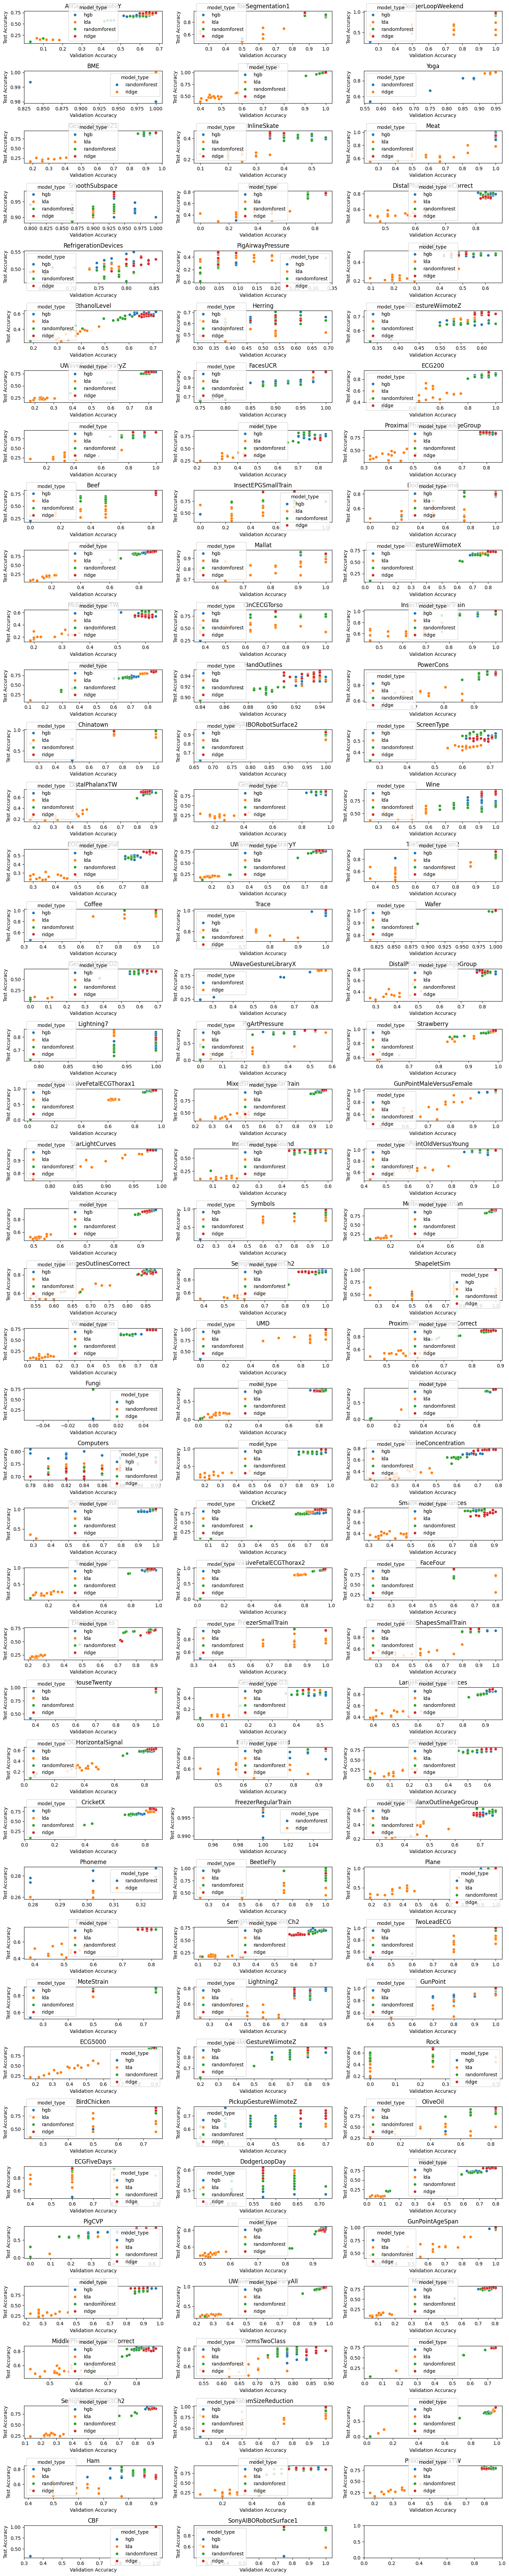

In [8]:
import seaborn as sns
fig, axs = plt.subplots(ncols=3, nrows=(len(datasets) + 3) // 3, figsize=(15, 75))
axs = axs.flatten()
for ds_ in datasets:
    df_ds = df.filter(pl.col("dataset") == ds_).sort('model')
    ax = axs[datasets.index(ds_)]
    sns.scatterplot(data=df_ds.to_pandas(), x="val_accuracy", y="test_accuracy", ax=ax, hue="model_type")
    ax.set_title(ds_)
    ax.set_xlabel("Validation Accuracy")
    ax.set_ylabel("Test Accuracy")
plt.tight_layout()

In [9]:
120//3

40